# Introduction

The motivation for this Jupyter notebook comes from questions I'e heard customers before?

_Can I see your data in my preferred environment?_
_Can I send your data to my preferred environment, such as Elasticsearch?_

Many people have their favorite data aggregators and dashboard tools.  This may be a BI tool, Elasticsearch, Grafana, or any number of outputs.  Sometimes people have one or more people working on the dashboarding team.  Who are we to say no?

This Jupyter noteboook takes Snyk output, and imports it into Elasticsearch.  This example is a proof-of-concept showing how we can extra data via the Snyk CLI and import it into Elasticsearch.  We do some lightweight configuration of our Elasticsearch index, and you will likely refine the field types.  Also, we only import a subset of all the fields, and you may choose to import even more.  In our datafiles directory, we have examples taken from publicly availalbe open-source examples.

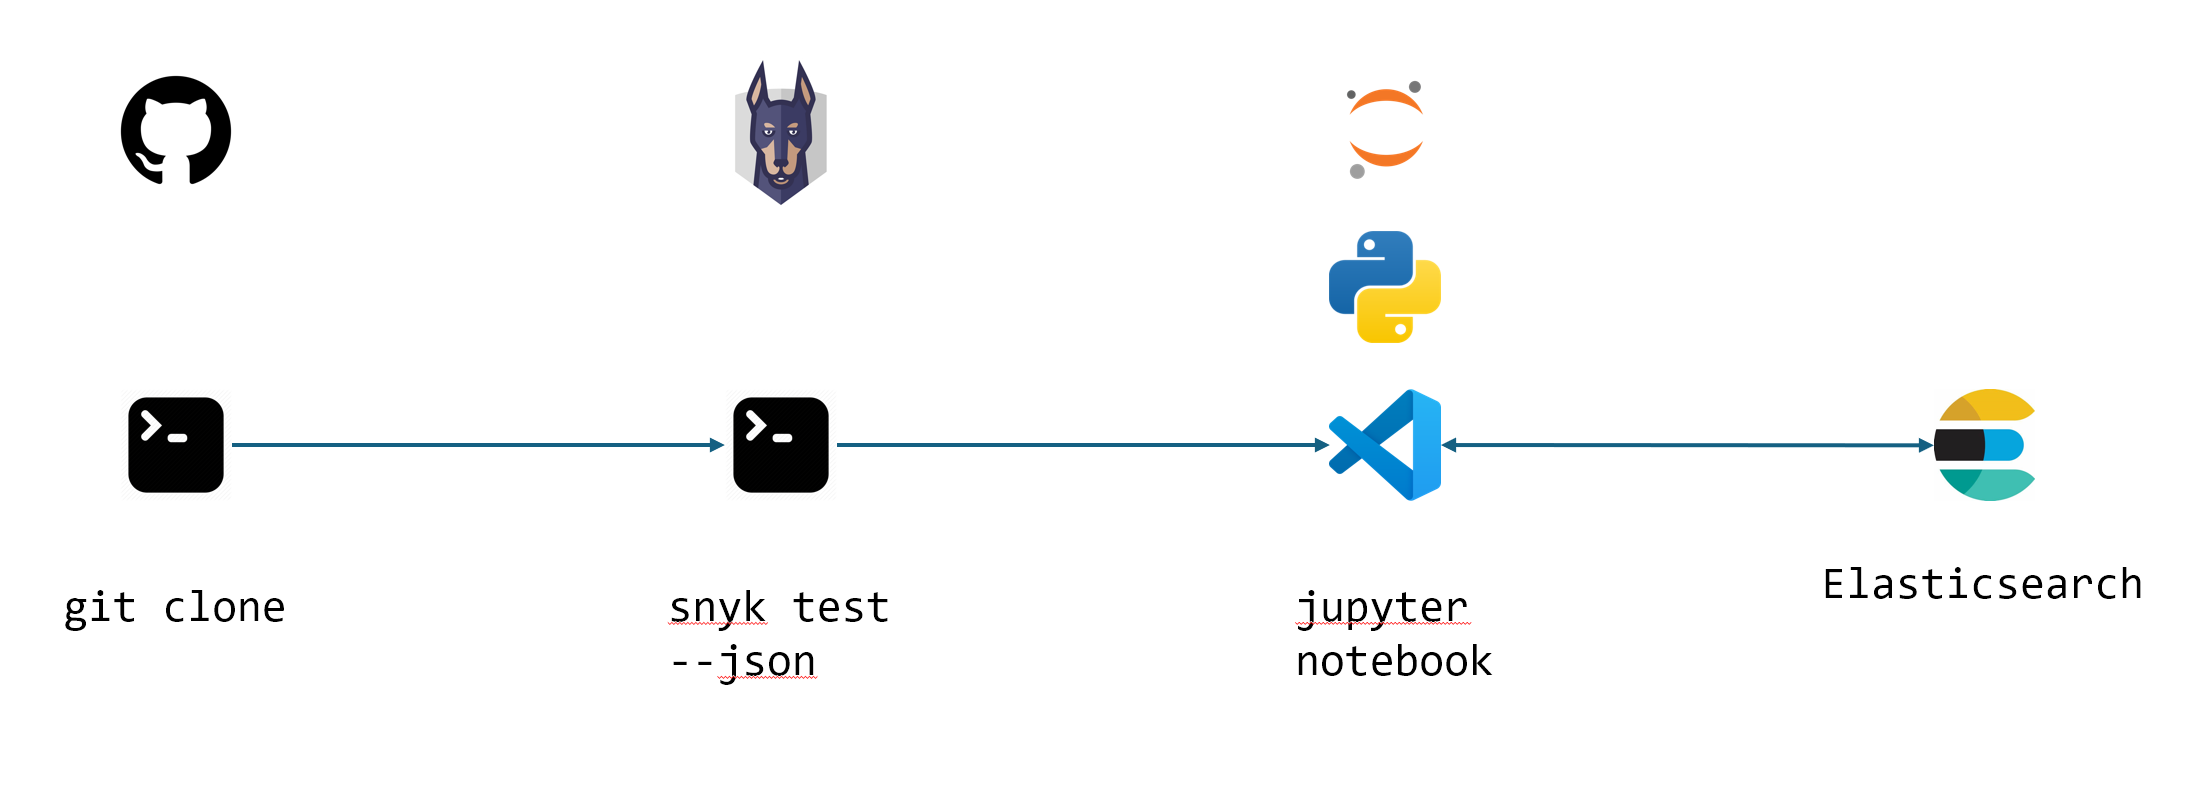


## What didn't happen
Ordinarily, I would use the snyk REST API, but that is not available on the Snyk free tier.  My desire was to use enhanced API queries to only select a subset of all vulnerabilities.  Next time, right?

I also tried web scraping, but that is difficult because the webpage uses OAUTH.  This made the problem tricky for a few reasons.  First, getting the OAUTH process to work with Python looks to be achievable, but it was beyond the scope of my timeframe for this POC.  Also, I knew I had to render page responses because of Javascript, but getting Selenium to work with modified headers for authentication was also a tricky expercise.  At least tricker than my time allowed.  _This means I decided not to pursue *that* strategy._

## What did happen
I take the JSON output from `snyk` CLI commands and process them with Python.  I use the Elasticsearch Python library to send data to my local, 2-node ElasticSearch cluster on my Ubuntu machine.  If you have the means to run ES locally, try it out.  It is mostly easy.

Once the data is in ElasticSearch, I run some simple queries with Python to prove the concept.  For example, on ES I will try some queries and some data representation.

## Input files

I use two types of files.  I'll lead with JSON files from the SnykCLI and use those as inputs into ES.  I'll also generate sarif files.  I expect most work to happen with the JSON files.

I tested the following on
- Ubuntu 24 LTS 
- Elasticsearch 8.15
- Python 3.12
- Snyk CLI 1.1293.1

These are the repositories that I used to generate the output files:
- git@github.com:marcoman/vulnado.git
- git@github.com:marcoman/java-goof.git
- git@github.com:marcoman/goof.git

These are the containers I used to generate output files:
- docker.elastic.co/elasticsearch/elasticsearch:8.15.1
- A local container built from https://github.com/marcoman/goof/tree/develop/todolist

For reference, these are some of the commands I ran to get my files:

```bash
snyk container test --json --json-file-output=container-elastic.json --app-vulns docker.elastic.co/elasticsearch/elasticsearch:8.15.1
snyk container test --json --json-file-output=container-todolist-goof.json --app-vulns todolist-goof:latest

snyk container test --sarif --sarif-file-output=container-todolist-goof.sarif --app-vulns todolist-goof:latest 
snyk container test --sarif --sarif-file-output=container-elastic.sarif --app-vulns docker.elastic.co/elasticsearch/elasticsearch:8.15.1

snyk test --json-file-output=os-goof-todolist.json --json
snyk test --json-file-output=os-java-goof.json --json
snyk test --json-file-output=os-vulnado.json --json

```

## SARIF files
At this time, I am not using the SARIF files.  I need to find a use case to import that data into a vulnerability-friendly processor.

## Limitations
I am using a free-tier instance of Elasticsearch, which means I don't have enhanced entitlements for some of the really neat stuff.  What I would like to test is the vulnerabilities module of Elasticsearch.  That is someting I haven't tried yet, and I might just try a trial cloud instance of Elasticsearch to see the results.  Next time!

## Getting started

Next, let's load up our environment with some data.  The assumption is you have data files to read.  I su pply some in the [datafiles](datafiles) folder for reference and use with this notebook.
These next lines setup our working environment and disable a warning we see on account of using unverified HTTPS requests.  In a production environment, you won't need that line of code.

In [5]:
import pandas as pd
import numpy as np
import json
from elasticsearch import Elasticsearch, helpers

import urllib3

# This call disables the InsecureRequestWarning for unverified HTTPS requests
# This is a common workaround for disabling SSL certificate verification in Python
# It should not be used in production environments, as it can lead to security risks
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

Let's load up our files and start to examine them.  The JSON files come in heavy, and we reduce or only load in a subset.  I encourage you to review some of the files to see their structure.


In [6]:
# We're going to load in files into a variable.  
# We *might* use the file contents as-is, but more likely just within a JSON object.
json_container_elastic = None
json_container_todolist = None
json_os_goof_todolist = None
json_os_java_goof = None
json_os_vulnado = None

with open('datafiles/container-elastic.json') as f:
    json_container_elastic = json.load(f)

with open('datafiles/container-todolist-goof.json') as f:
    json_container_todolist = json.load(f)

with open('datafiles/os-goof-todolist.json') as f:
    json_os_goof_todolist = json.load(f)

with open('datafiles/os-java-goof.json') as f:
    json_os_java_goof = json.load(f)

with open('datafiles/os-vulnado.json') as f:
    json_os_vulnado = json.load(f)


This next part gets our envrionment variables to collect our API credentials.  In my environment, I set these values envvars to help me avoid adding them to the code.  

My Elasticsearch server is on my computer, and it is not likely the world will be attacking it.  Still, it is a good practice to use envvars rather than hard-coding the values here.

In [7]:
import os
ELASTIC_API_URL = os.environ.get('ELASTIC_API_URL')
ELASTIC_API_KEY = os.environ.get('ELASTIC_API_KEY')
#The authorization headers are by username + password
headers = {
    'Authorization': f'ApiKey {ELASTIC_API_KEY}'
}   


For fun, we print out the URL to ensure that we really do have values defined.

In [8]:
print(ELASTIC_API_URL)


https://172.29.213.51:9200/


# Test Elasticsearch connection

As a test, let's see if we access the ES server via a requests call.  This is different from using the ES library, which we'll test later.
We are still in the setup phase.  These steps are especially good if you are new to the technology we're using here.

In [9]:
import requests

## Read the products from the Elastic Server.  This is a GET request to /products
def get_products():
    url = f"{ELASTIC_API_URL}/products"
    
    # We specify verify=False to match curl's --insecure flag
    response = requests.get(url, headers=headers, verify=False)
    return response.json()


products = get_products()
print (f'Your products are: \n{products}')


Your products are: 
{'products': {'aliases': {}, 'mappings': {'properties': {'created': {'type': 'date', 'format': 'yyyy/MM/dd HH:mm:ss||yyyy/MM/dd||epoch_millis'}, 'description': {'type': 'text', 'fields': {'keyword': {'type': 'keyword', 'ignore_above': 256}}}, 'id': {'type': 'long'}, 'in_stock': {'type': 'long'}, 'is_active': {'type': 'boolean'}, 'name': {'type': 'text', 'fields': {'keyword': {'type': 'keyword', 'ignore_above': 256}}}, 'price': {'type': 'long'}, 'sold': {'type': 'long'}, 'tages': {'type': 'text', 'fields': {'keyword': {'type': 'keyword', 'ignore_above': 256}}}, 'tags': {'type': 'text', 'fields': {'keyword': {'type': 'keyword', 'ignore_above': 256}}}}}, 'settings': {'index': {'routing': {'allocation': {'include': {'_tier_preference': 'data_content'}}}, 'number_of_shards': '2', 'provided_name': 'products', 'creation_date': '1726425825891', 'number_of_replicas': '2', 'uuid': 'tPcO96JhRLqzI7bhDZSGXQ', 'version': {'created': '8512000'}}}}}


Back to the snyk cli output files. 

The general structure of the json file is below.  These are organized with a few differet top-level lists, and we'll spend most of our time focusing on the `vulnerabilities` and `applications` lists.  As I work over the examples, I am expecting to use the `projectName` and `path` as identifiers or query criteria.  This means I'm likely to add all vulnerabilities and application to their respective indicies, and the query will be my filter.

```json
{
    "vulnerabilities": [],
    ...
    "summary" : "",
    "projectName" : "",
    "path" : "",
    "applications" : [
        {
            "projectName":"",
            "dependencyCount":"",
            "displayTargetFile":"",
            "targetFile":"",
            "path":"",
            "packageManager":"",
            "summary" : "",
            "vulnerabilities":[]
        }
    ]
}
```


In [10]:
# Initialize the Elasticsearch client and use the API key to log on.


from elasticsearch import Elasticsearch
es = Elasticsearch(ELASTIC_API_URL, api_key=ELASTIC_API_KEY, verify_certs=False)

/home/marco/code/marcoman/marcoman/venv/lib/python3.12/site-packages/elasticsearch/_sync/client/__init__.py:400: SecurityWarning: Connecting to 'https://172.29.213.51:9200' using TLS with verify_certs=False is insecure
  _transport = transport_class(


## Reset

I delete my indicies to start from scratch.  This helps me work with known quanities each time.

In [11]:
# Clean up indicies to start clean
# Delete only if the indicies are present.

if es.indices.exists(index='applications'):
    print("Deleting index applications")
    res = es.indices.delete(index='applications')
    print(res)
else:
    print("Index applications does not exist")

if es.indices.exists(index='vulnerabilities'):
    print("Deleting index vulnerabilities")
    res = es.indices.delete(index='vulnerabilities')
    print(res)
else:
    print("Index vulnerabilities does not exist")


Deleting index applications
{'acknowledged': True}
Deleting index vulnerabilities
{'acknowledged': True}


## Create indicies for our test

I create indicies for both `applications` and `vulnerabilities` explicitly.  

In a product environment, we would tailor the creation of the indicies to provide better results based on the fields.  As a simple example, we might want to quantify the severities into a known list to make it easier to categorize the results.  At this time, the list of `["CRITICAL", "HIGH", "MEDIUM", "LOW"]` are treated as text strings (or tokens), but don't have an intrinsic enumerated value.  In a production environment, it may be better to correlate these to a numerical value to save space and increase speed.

In [12]:
index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    }
}

if not es.indices.exists(index="applications"):
    response = es.indices.create(index="applications", body=index_settings)

if not es.indices.exists(index="vulnerabilities"):
    response = es.indices.create(index="vulnerabilities", body=index_settings)


## Populate the indicies

This section contains the real implementation of how we send data to Elasticsearch.
I use the `elasticsearch` python library.  I could have used the `urllib` libray, but that would have been much more work.  

I iterate through the JSON file and add a subset of the data to the indicies.  That is visible in the different maps that make up the document we sent to the elasticsearch library.  You may want to explore options and modify the body.  In this example, you can very easily add new fields with no penalty.  Use caution when removing fields, because later we use their names to search for results.

In [13]:
json_files = [["Elasticsearch container", json_container_elastic, "container"],
              ["Java TODO List container", json_container_todolist, "container"],
              ["Goof Open Source", json_os_goof_todolist, "opensource"],
              ["Java Goof Open Source", json_os_java_goof, "opensource"],
              ["Vulnado Open Source", json_os_vulnado, "opensource"],
              ]

def iterate_through_containers(jsonfile):
    # we want to iterate and report on two lists inside of the Json body named jsonfile.
    # The first is named applications, and the second is named vulnerabilities.  
    # These two lists are independent and at the same level
    # Read through each and print out their contents
    print(f'Operating on {jsonfile[0]}')
    projectName = jsonfile[1]['projectName']
    path = jsonfile[1]['path']
    
    print(f'Working on {projectName} with {path}')

    i = 0
    for app in jsonfile[1]['applications']:
        # print(app)
        # Now load each app named "app" as a new document in ElasticSearch into the index named "applications"
        # There is variation in the records and I need to adjust how they are stored.  For example, the upgradePath is empty or contains values.async_search
        # For this part, I'll create a new record that is just a subset of the original.
        if "vulnerable dependency path" in app['summary']:
            # We know the first token is a number, so let's get it and render it as an integer
            vulns = int(app['summary'].split(' ')[0])
        else:
            vulns = 0
            
        newapp = {
            "projectName" : projectName,
            "path" : path,
            "appProjectName": app['projectName'],
            "targetFile": app['targetFile'],
            "summary": app['summary'],
            "displayTargetFile": app['displayTargetFile'],
            "id" : i,
            "vulns" : vulns
        }
        es.index(index="applications", document=newapp)
        i += 1
    print(f'There are {i} applications')

    i = 0        
    for vuln in jsonfile[1]['vulnerabilities']:
        # print(vuln)
        newvuln = {
            "projectName" : projectName,
            "path" : path,
            "id": vuln['id'],
            "CVSSv3": vuln['CVSSv3'],
            "cvssScore": vuln['cvssScore'],
            "description": vuln['description'],
            "packageName": vuln['packageName'],
        }
        es.index(index="vulnerabilities", document=newvuln)
        i += 1
    print(f'There are {i} vulnerabilities')
    
def iterate_through_opensource(jsonfile):
    print(f'Operating on {jsonfile[0]}')
    projectName = jsonfile[1]['projectName']
    path = jsonfile[1]['path']
    packageManager = jsonfile[1]['packageManager']
    print(f'Working on {projectName} with {path} and {packageManager}')
    i = 0
    for vuln in jsonfile[1]['vulnerabilities']:
        newvuln = {
            "projectName" : projectName,
            "path" : path,
            "packageManager" : packageManager,
            "CVSSv3": vuln['CVSSv3'],
            "cvssScore": vuln['cvssScore'],
            "id": vuln['id'],
            "language" : vuln['language'],
            "packageName" : vuln['packageName'],
            "severity": vuln['severity'],
            "description": vuln['description'],
            "packageName": vuln['packageName'],
        }
        es.index(index="vulnerabilities", document=newvuln)
        i += 1
    print(f'There are {i} vulnerabilities')

for jsonfile in json_files:
    if jsonfile[2] == "container":
        iterate_through_containers(jsonfile=jsonfile)
    elif jsonfile[2] == "opensource":
        iterate_through_opensource(jsonfile=jsonfile)
   


Operating on Elasticsearch container
Working on docker-image|docker.elastic.co/elasticsearch/elasticsearch with docker.elastic.co/elasticsearch/elasticsearch:8.15.1/elasticsearch/elasticsearch
There are 94 applications
There are 104 vulnerabilities
Operating on Java TODO List container
Working on docker-image|todolist-goof with todolist-goof:latest
There are 7 applications
There are 2293 vulnerabilities
Operating on Goof Open Source
Working on io.github.snyk:todolist-mvc with /home/marco/code/marcoman/goof/todolist and maven
There are 0 vulnerabilities
Operating on Java Goof Open Source
Working on io.github.snyk:java-goof with /home/marco/code/marcoman/java-goof and maven
There are 0 vulnerabilities
Operating on Vulnado Open Source
Working on com.scalesec:vulnado with /home/marco/code/marcoman/vulnado and maven
There are 126 vulnerabilities


Now that we've imported vulnerabilities from a few container and a few open-source projects, let's see what extra details or insights we can get.

NOTE: Some projects did not have vulnerabilities.  Also, with the free tier, we may be limited in the total number of scans we can run.

Let's start by getting a count of records that match our search criteria.  Since all of the data is in two different indicies, I will be looking for unique values.

In [14]:
# Let's get the number of unique projectName values in the applications and vulnerabiliities indicies
# We will use query results from elasticsearch.

# Define the aggregation query
query = {
    "size": 0,
    "aggs": {
        "unique_project_names": {
            "terms": {
                "field": "projectName.keyword",
                "size": 10000  # Adjust the size as needed
            }
        }
    }
}

# Execute the search query
response = es.search(index="applications", body=query)

# Extract the unique project names
app_project_names = [bucket['key'] for bucket in response['aggregations']['unique_project_names']['buckets']]

# Print the unique project names
print("\nUnique project names in applications index:")
for project_name in app_project_names:
    print(project_name)

# now let's do the same for the vulnerabilities index.  Same query
response = es.search(index="vulnerabilities", body=query)
vuln_project_names = [bucket['key'] for bucket in response['aggregations']['unique_project_names']['buckets']]
print("\nUnique project names in vulnerabilities index:")
for project_name in vuln_project_names:
    print(project_name)
    


Unique project names in applications index:
docker-image|docker.elastic.co/elasticsearch/elasticsearch
docker-image|todolist-goof

Unique project names in vulnerabilities index:
docker-image|todolist-goof
docker-image|docker.elastic.co/elasticsearch/elasticsearch
com.scalesec:vulnado


# Elasticsearch query examples

Here are some ideas:

* How many vulnerabilities for each of the application index?
* How may Critical, High, Medium, Low vulnerabilities do we have for each container?


In [15]:
print("Application type count for each of our projects.")
for project_name in app_project_names:
    print(f"Project: {project_name}")
    # do an elasticsearch query for the project_name in the applications index, for the vulnerabilities of each type -
    # critical, high, medium, low
    # app_critical = es.search(index="applications", query={"match": {"project_name": project_name, "severity": "critical"}})
    
    
    app_critical = es.search(index="applications",
                             query= {"bool": {
                                 "must" : [
                                     { "range" : {
                                         "vulns" : {"gt" : 0}
                                         }
                                     },
                                     { "term" : {"projectName.keyword" : project_name}}
                                     ]
                                 }},
                             size=0,
                             aggs={
                                 "vuln_count" : {
                                     "value_count" : {
                                         "field" : "vulns.keyword"
                                     }
                                 }
                             },
                             )
    print(f"Apps with vulns: {app_critical['hits']['total']['value']}")

print("\n\nVulnerability type count for each of our projects.")
for unique_project in vuln_project_names:
    print(f"Project: {unique_project}")
    vuln_critical = es.search(index="vulnerabilities",
                             query= {"bool": {
                                 "must" : [
                                     { "match" : {"severity" : "critical"}},
                                     { "term" : {"projectName.keyword" : unique_project}}
                                     ]
                                 }},)
    print(f"Critical: {vuln_critical['hits']['total']['value']}")

    vuln_high = es.search(index="vulnerabilities",
                             query= {"bool": {
                                 "must" : [
                                     { "match" : {"severity" : "high"}},
                                     { "term" : {"projectName.keyword" : unique_project}}
                                     ]
                                 }},)
    print(f"High: {vuln_high['hits']['total']['value']}")

    vuln_med = es.search(index="vulnerabilities",
                             query= {"bool": {
                                 "must" : [
                                     { "match" : {"severity" : "medium"}},
                                     { "term" : {"projectName.keyword" : unique_project}}
                                     ]
                                 }},)
    print(f"Med: {vuln_med['hits']['total']['value']}")
    
    vuln_low = es.search(index="vulnerabilities",
                             query= {"bool": {
                                 "must" : [
                                     { "match" : {"severity" : "low"}},
                                     { "term" : {"projectName.keyword" : unique_project}}
                                     ]
                                 }},)
    print(f"Low: {vuln_low['hits']['total']['value']}")

Application type count for each of our projects.
Project: docker-image|docker.elastic.co/elasticsearch/elasticsearch
Apps with vulns: 6
Project: docker-image|todolist-goof
Apps with vulns: 2


Vulnerability type count for each of our projects.
Project: docker-image|todolist-goof
Critical: 0
High: 0
Med: 0
Low: 0
Project: docker-image|docker.elastic.co/elasticsearch/elasticsearch
Critical: 0
High: 0
Med: 0
Low: 0
Project: com.scalesec:vulnado
Critical: 0
High: 27
Med: 4
Low: 0


This next section does a quick sanity check of our results.  If we use plain-old grep, we'll match on more lines than intended because of nesting.  That is most easily seen in the vulnerability counts for the `container-*.json` files, which include a summary.

TODO: the next step for the open source examples is to perform a `jq` filter on the right level of the JSON file.  A plain-old grep is not good enough, because of how the results are nested.

In [16]:
# This shell script performs a grep to match some of the same values
!echo "This result includes "one more" for a top-level summary"
!grep summary datafiles/container-elastic.json  | grep -v "No known" | wc

!echo "This result includes "one more" for a top-level summary"
!grep summary datafiles/container-todolist-goof.json  | grep -v "No known" | wc


This result includes one more for a top-level summary


      7      35     345
This result includes one more for a top-level summary
      3      15     152


## Plots

Let's try a few simple charts to illustrate possibilities.
I'll first start by showing bar charts of the vulnerabilities in our containers.  For this one, we have simple data, so showing a bar chart should suffice.


In [17]:
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns


Text(0.5, 1.0, 'Number of vulnerabilities per application')

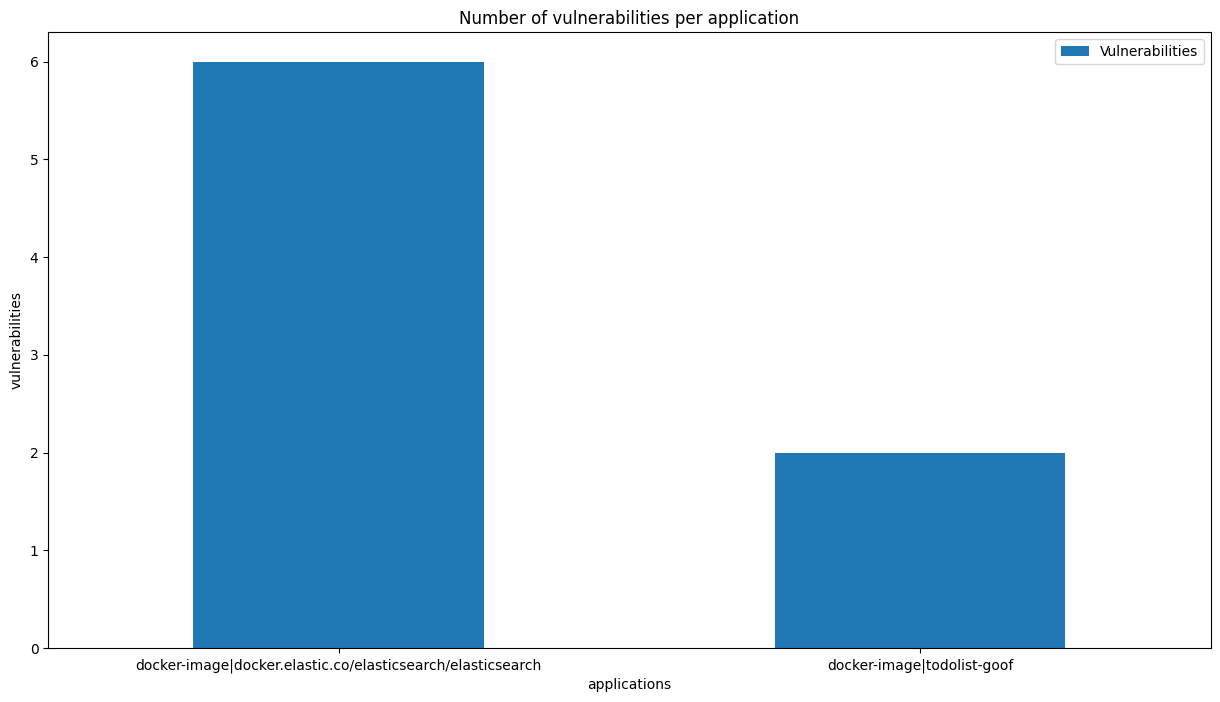

In [28]:
# Programmatically iterate through our list of containers, and display their vulnerability counts on a bar chart.

import pandas as pd
df = pd.DataFrame(columns=['Application', 'Vulnerabilities'])

for project_name in app_project_names:
    app_critical = es.search(index="applications",
                             query= {"bool": {
                                 "must" : [
                                     { "range" : {
                                         "vulns" : {"gt" : 0}
                                         }
                                     },
                                     { "term" : {"projectName.keyword" : project_name}}
                                     ]
                                 }},
                             size=0,
                             aggs={
                                 "vuln_count" : {
                                     "value_count" : {
                                         "field" : "vulns.keyword"
                                     }
                                 }
                             },
                             )
    # print(f"Apps with vulns: {app_critical['hits']['total']['value']}")
    # use panda's concat method to add a new row to the dataframe
    df = pd.concat([df, pd.DataFrame.from_records([{'Application' : project_name,
                                                     'Vulnerabilities' : app_critical['hits']['total']['value']}])])

# Set the size of the figure to be larger.
plt.rcParams['figure.figsize'] = (15, 8)
df.plot.bar(x='Application', y='Vulnerabilities', rot=0)

plt.xlabel('applications')
plt.ylabel('vulnerabilities')
plt.title('Number of vulnerabilities per application')

Now let's try the same with the vulnerabilties index.


Low: 0
Low: 0
Low: 9


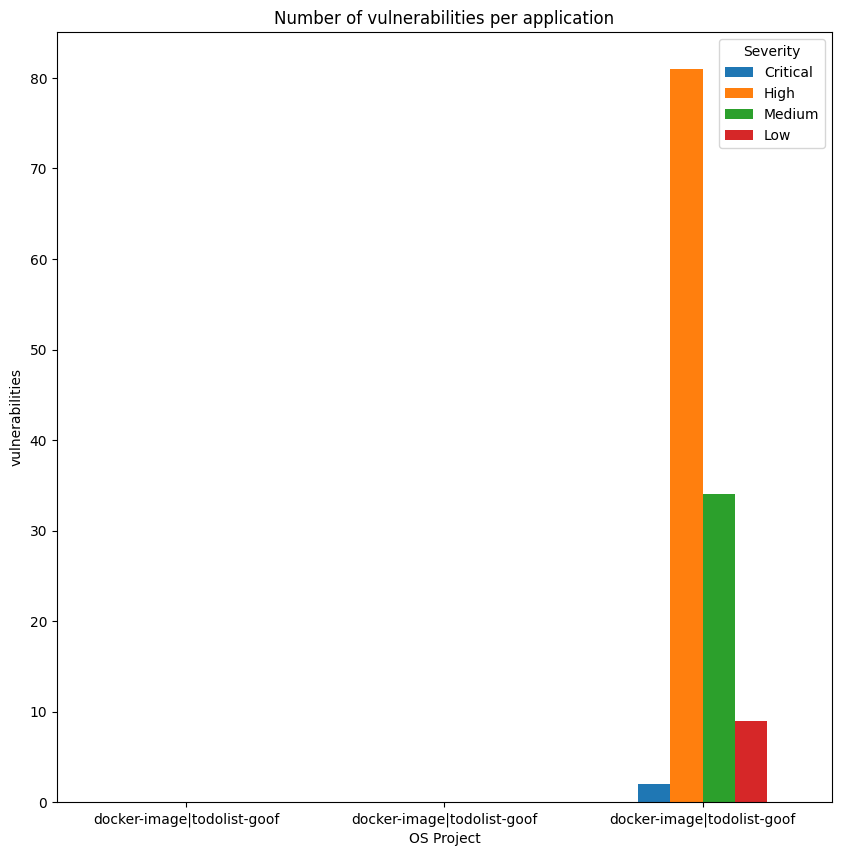

In [35]:
# Programmatically iterate through our list of open source projects, and display their vulnerability counts on a bar chart.

import pandas as pd
df = pd.DataFrame(columns=['OS Project', 'Critical', 'High', 'Medium', 'Low'])

for unique_project in vuln_project_names:
    vuln_critical = es.search(index="vulnerabilities",
                             query= {"bool": {
                                 "must" : [
                                     { "match" : {"severity" : "critical"}},
                                     { "term" : {"projectName.keyword" : unique_project}}
                                     ]
                                 }},)
    vuln_high = es.search(index="vulnerabilities",
                             query= {"bool": {
                                 "must" : [
                                     { "match" : {"severity" : "high"}},
                                     { "term" : {"projectName.keyword" : unique_project}}
                                     ]
                                 }},)
    vuln_med = es.search(index="vulnerabilities",
                             query= {"bool": {
                                 "must" : [
                                     { "match" : {"severity" : "medium"}},
                                     { "term" : {"projectName.keyword" : unique_project}}
                                     ]
                                 }},)
    vuln_low = es.search(index="vulnerabilities",
                             query= {"bool": {
                                 "must" : [
                                     { "match" : {"severity" : "low"}},
                                     { "term" : {"projectName.keyword" : unique_project}}
                                     ]
                                 }},)
    print(f"Low: {vuln_low['hits']['total']['value']}")

    df = pd.concat([df, pd.DataFrame.from_records([{'OS Project' : project_name,
                                                     'Critical' : vuln_critical['hits']['total']['value'],
                                                     'High' : vuln_high['hits']['total']['value'],
                                                     'Medium' : vuln_med['hits']['total']['value'],
                                                     'Low' : vuln_low['hits']['total']['value']
                                                     }])])




# Set the size of the figure to be larger.
df.set_index('OS Project', inplace=True)
ax = df.plot.bar(rot=0, figsize=(10,10))
ax.set_title('Number of vulnerabilities per application')
ax.set_xlabel('OS Project')
ax.set_ylabel('vulnerabilities')
plt.legend(title="Severity")
plt.show()